In [1]:
from utils import pickle_load
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

train_embs = pickle_load(r"D:/train_embs.pkl")
test_embs = pickle_load(r"D:/test_embs.pkl")
train_df = pd.read_csv('train.csv')

In [11]:
train_df

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,beluga,5ac053677ed1
51029,fff8b32daff17e.jpg,cuviers_beaked_whale,1184686361b3
51030,fff94675cc1aef.jpg,blue_whale,5401612696b9
51031,fffbc5dd642d8c.jpg,beluga,4000b3d7c24e


In [2]:
from collections import defaultdict
from tqdm import tqdm

def dict2list(embs):
    keys = list(embs.keys())
    values = [embs[k] for k in keys]
    return keys, np.stack(values)

def compute_sim(train_embs, test_embs):
    # Compute center of each individual id
    label2emb = defaultdict(list)
    for label, d in train_df.groupby('individual_id'):
        for img_id in d.image.values:
            if img_id in train_embs:
                label2emb[label].append(train_embs[img_id])

    for k, v in label2emb.items():
        avg = np.mean(np.stack(v), 0)
        label2emb[k] = avg / np.linalg.norm(avg)

    train_k, train_v = dict2list(label2emb)
    test_k, test_v = dict2list(test_embs)

    cos = np.matmul(test_v, train_v.T)

    records = []

    for i, scores in enumerate(tqdm(cos)):
        sort_idx = np.argsort(scores)[::-1]
        top5 = [train_k[j] for j in sort_idx[:5]]

        for j in range(5):
            sim_score = scores[sort_idx[j]]
            if j == 1:#sim_score < 0.5:
                top5 = top5[:j] + ['new_individual'] + top5[j:4]
                break
            
        records.append([test_k[i], " ".join(top5)])

    sim_df = pd.DataFrame(records, columns=['image', 'predictions'])
    sim_df[["image", "predictions"]].to_csv("submission.csv", index=False)
    return sim_df

sim_df = compute_sim(train_embs, test_embs)

100%|██████████| 27956/27956 [00:23<00:00, 1186.03it/s]


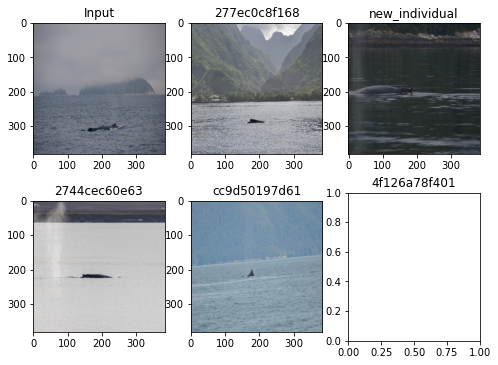

In [10]:
def random_show(sim_df):
    sample = sim_df.iloc[np.random.choice(sim_df.index)]
    img1 = cv2.imread(f'D:/whale_data/test_images-384-384/test_images-384-384/{sample.image}')[:, :, ::-1]
    imgs = [img1]

    ids = sample.predictions.split(" ")
    for i in range(5):
        if ids[i] != 'new_individual':
            path = train_df[train_df.individual_id == ids[i]].values[0][0]
            img = cv2.imread(f'D:/whale_data/train_images-384-384/train_images-384-384/{path}')[:, :, ::-1]
            imgs.append(img)

    fig = plt.figure(figsize=(8, 6))
    columns = 3
    rows = 2
    for i in range(0, columns*rows):
        fig.add_subplot(rows, columns, i+1)
        if i == 0:
            plt.title('Input')
        else:
            plt.title(ids[i-1])
        if i < len(imgs):
            plt.imshow(imgs[i])
    plt.show()

random_show(sim_df)

In [4]:
# from sklearn.neighbors import NearestNeighbors
# knn = NearestNeighbors(n_neighbors=100,metric='cosine')

# train_k, train_v = dict2list(train_embs)
# test_k, test_v = dict2list(test_embs)
# knn.fit(train_v)


In [5]:
# test_df = []
# train_k = np.asarray(train_k)

# for i in tqdm(range(len(test_k))):
#     distances, idxs = knn.kneighbors(np.expand_dims(test_v[i], 0), 5, return_distance=True)
#     targets = train_k[idxs[0]]
#     # print(targets)
#     subset_preds = pd.DataFrame(np.stack([targets, distances[0]],axis=1),columns=['target','distances'])
#     subset_preds['image'] = test_k[i]
#     test_df.append(subset_preds)

# test_df = pd.concat(test_df).reset_index(drop=True)
# test_df['confidence'] = 1-test_df['distances']
# test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
# test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
# test_df['target'] = test_df['target'].map(target_encodings)
# test_df.to_csv('test_neighbors.csv')
# test_df.image.value_counts().value_counts()